In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### merge unit-profile and excluded unit files for april2012 and sept2012

In [137]:
april_profile = pd.read_csv("../unit_profile_files/unit-profile-april2012.csv")
sept_profile = pd.read_csv("../unit_profile_files/unit-profile-sept2012.csv")

combined_profile2012 = pd.concat([april_profile, sept_profile]).drop_duplicates(subset=["Unit ID"]).reset_index(drop=True)
combined_profile2012.to_csv("../unit_profile_files/unit-profile-combined2012.csv", index=False)

april_excluded = pd.read_excel("../unit_profile_files/units-excluded-april2012.xlsx")
april_excluded.rename(columns={april_excluded.columns[1]: "ISP", april_excluded.columns[0]: "Unit ID"}, inplace=True)
sept_excluded = pd.read_excel("../unit_profile_files/units-excluded-sept2012.xlsx")
sept_excluded.rename(columns={sept_excluded.columns[1]: "ISP", sept_excluded.columns[0]: "Unit ID"}, inplace=True)

combined_excluded2012 = pd.concat([april_excluded, sept_excluded]).drop_duplicates(subset=["Unit ID"]).reset_index(drop=True) # removes duplicate entries for unit ids
combined_excluded2012.to_excel("../unit_profile_files/units-excluded-combined2012.xlsx", index=False)

In [210]:
unit_files = [
    "../unit_profile_files/unit-profile-march2011.csv", # report yr'11
    "../unit_profile_files/unit-profile-combined2012.csv", # report yr'12
    "../unit_profile_files/unit-profile-sept2013.csv",  # report yr'13
    "../unit_profile_files/unit-profile-sept2014.csv",
    "../unit_profile_files/unit-profile-sept2015.csv",
    "../unit_profile_files/unit-profile-sept2016.csv",
    "../unit_profile_files/unit-profile-sept2017.csv",
    "../unit_profile_files/unit-profile-sept2018.csv",
    "../unit_profile_files/unit-profile-sept2019.csv",
    "../unit_profile_files/unit-profile-sept2020.csv", 
    "../unit_profile_files/unit-profile-sept2021.csv", 
]

unit_isp_mapping = {}
start_yr = 2011

prev_df = pd.DataFrame([], columns=["Unit ID", "ISP", "Technology"])
tech_stats_df = pd.DataFrame()
isp_stats_df = pd.DataFrame()
units_stats = []

for id, unit_file in enumerate(unit_files):
    profile = pd.read_csv(unit_file)

    year = start_yr + id
    # unit_profile = pd.read_csv("../unit_profile_files/unit-profile-march2011.csv")

    # for 2020 and 2018
    profile["ISP"] = profile["ISP"].str.strip()
    profile["ISP"] = profile["ISP"].replace("Verizon DSL", "Verizon")
    profile["ISP"] = profile["ISP"].replace("Verizon Fiber", "Verizon")
    profile["ISP"] = profile["ISP"].replace("Verizon Wireless", "Verizon")
    profile["ISP"] = profile["ISP"].replace("Hawaiian Telcom", "Hawaiian Telecom")
    # for 2016
    profile["ISP"] = profile["ISP"].replace("AT&T DSL", "AT&T")
    profile["ISP"] = profile["ISP"].replace("AT&T IPBB", "AT&T")
    profile["ISP"] = profile["ISP"].replace("Cincinnati Bell DSL", "Cincinnati Bell")
    profile["ISP"] = profile["ISP"].replace("Cincinnati Bell Fiber", "Cincinnati Bell")
    profile["ISP"] = profile["ISP"].replace("Frontier DSL", "Frontier")
    profile["ISP"] = profile["ISP"].replace("Frontier Fiber", "Frontier")
    profile["ISP"] = profile["ISP"].replace("Time Warner Cable", "TimeWarner")

    profile["Technology"] = profile["Technology"].str.strip()
    profile["Technology"] = profile["Technology"].replace("CABLE", "Cable")
    profile["Technology"] = profile["Technology"].replace("CABLE - BUSINESS", "Cable")
    profile["Technology"] = profile["Technology"].replace("FIBER", "Fiber")
    profile["Technology"] = profile["Technology"].replace("SATELLITE", "Satellite")
    profile["Technology"] = profile["Technology"].replace("SAT", "Satellite")

    stats_isp = profile.groupby(['ISP']).agg({'Unit ID': 'count'})
    stats_tech = profile.groupby(['Technology']).agg({'Unit ID': 'count'})
    stats_isp = stats_isp.T
    stats_tech = stats_tech.T
    stats_isp.insert(loc=0, column="Year", value=year)
    stats_tech.insert(loc=0, column="Year", value=year)
    tech_stats_df = pd.concat([tech_stats_df, stats_tech]).reset_index(drop=True)
    isp_stats_df = pd.concat([isp_stats_df, stats_isp]).reset_index(drop=True)
    # print(stats_isp.to_markdown(tablefmt="grid"))
    # print(stats_tech.to_markdown(tablefmt="grid"))


    prev_ids = set(prev_df["Unit ID"].unique().tolist())
    new_ids = set(profile["Unit ID"].unique().tolist())
    units_stats.append([
        f"{year}", # year
        len(new_ids), # count of ids"
        len(prev_ids - new_ids), # removed IDs
        len(new_ids - prev_ids), # new IDS
    ])

    
    profile["combined"] = profile[["ISP", "Technology"]].values.tolist()
    temp_dict = dict(zip(profile["Unit ID"], profile["combined"]))
    unit_isp_mapping.update(temp_dict)
    prev_df = profile.copy()

combined_unit_profile = pd.DataFrame([[unit_id, str(operator_name).strip(), str(operator_technology).strip()] for unit_id, (operator_name, operator_technology) in unit_isp_mapping.items()],
                       columns=["Unit ID", "ISP", "Technology"])
units_stats = pd.DataFrame(units_stats, columns=["Year", "Count", "Removed IDs", "New IDs"])
# units_stats["Percentage"] = round((units_stats["Count"]/units_stats["New IDs"].sum())*100, 1)

# fill nan with 0
tech_stats_df = tech_stats_df.fillna(0)
isp_stats_df = isp_stats_df.fillna(0)

# drop first column containing on value Unit ID after performing group by agg
# tech_stats_df.drop(columns=tech_stats_df.columns[0], axis=1, inplace=True)
# isp_stats_df.drop(columns=isp_stats_df.columns[0], axis=1, inplace=True)

## Overall summary 

### count trend over the years

In [211]:
units_stats.loc['Total'] = units_stats[['New IDs']].sum()
units_stats = units_stats.fillna('')
print(units_stats.to_markdown(tablefmt="grid", floatfmt=""))

+-------+--------+---------+---------------+-----------+
|       | Year   | Count   | Removed IDs   |   New IDs |
+=======+========+=========+===============+===========+
| 0     | 2011   | 7377.0  | 0.0           |    7377.0 |
+-------+--------+---------+---------------+-----------+
| 1     | 2012   | 8416.0  | 1721.0        |    2760.0 |
+-------+--------+---------+---------------+-----------+
| 2     | 2013   | 6492.0  | 3227.0        |    1303.0 |
+-------+--------+---------+---------------+-----------+
| 3     | 2014   | 6323.0  | 1752.0        |    1583.0 |
+-------+--------+---------+---------------+-----------+
| 4     | 2015   | 6241.0  | 1790.0        |    1708.0 |
+-------+--------+---------+---------------+-----------+
| 5     | 2016   | 4545.0  | 2694.0        |     998.0 |
+-------+--------+---------+---------------+-----------+
| 6     | 2017   | 4378.0  | 1838.0        |    1671.0 |
+-------+--------+---------+---------------+-----------+
| 7     | 2018   | 3192.0  | 25

### ISP count over the years

In [212]:
print(isp_stats_df.to_markdown(tablefmt="grid"))

+----+--------+--------+---------------+---------------+---------------+-----------+-------------+-----------+-------+------------+----------+-----------+------------+---------+--------------+-----------+-------------------+--------------+-----------------+-------+------------+-------------------+-------------+-----------+------------+--------------------+---------------+-------+-----------+-------+
|    |   Year |   AT&T |   Brighthouse |   Cablevision |   CenturyLink |   Charter |   Clearwire |   Comcast |   Cox |   Frontier |   Hughes |   Insight |   Mediacom |   Qwest |   TimeWarner |   Verizon |   Wildblue/ViaSat |   Windstream |   Miscellaneous |   RCN |   CableONE |   Cincinnati Bell |   EarthLink |   EnTouch |   Fluidata |   Hawaiian Telecom |   Oceanic TWC |   Sky |   Optimum |   TWC |
+====+========+========+===============+===============+===============+===========+=============+===========+=======+============+==========+===========+============+=========+==============+==

In [209]:
len(isp_stats_df.columns)-1

37

## Technology count over the years

In [145]:
print(tech_stats_df.to_markdown(tablefmt="grid"))

+----+--------+---------+-------+---------+-------------+------------+----------+--------+----------+--------+------------------+
|    |   Year |   Cable |   DSL |   Fiber |   Satellite |   WIRELESS |   REMOVE |   MISC |   UVERSE |   IPBB |   Fixed Wireless |
+====+========+=========+=======+=========+=============+============+==========+========+==========+========+==================+
|  0 |   2011 |    4072 |  2595 |     551 |          67 |         83 |        0 |      0 |        0 |      0 |                0 |
+----+--------+---------+-------+---------+-------------+------------+----------+--------+----------+--------+------------------+
|  1 |   2012 |    4576 |  2663 |     872 |         116 |         53 |        0 |      0 |        0 |      0 |                0 |
+----+--------+---------+-------+---------+-------------+------------+----------+--------+----------+--------+------------------+
|  2 |   2013 |    3762 |  1878 |     729 |          71 |          0 |        0 |      0 |

## Visualizations of trend per year

### count per year

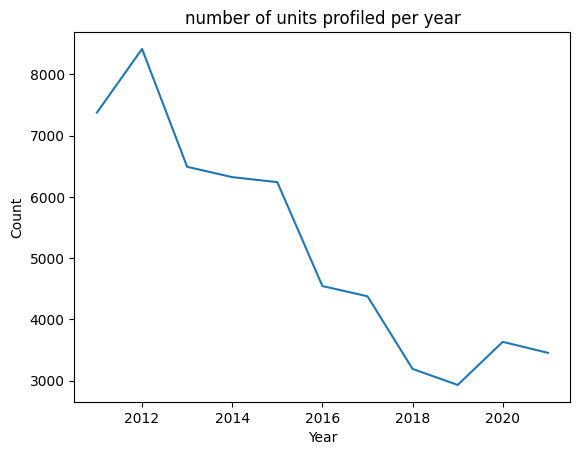

In [146]:
plt.plot(list(map(int, units_stats["Year"].to_list()[:-1])), units_stats["Count"][:-1])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("number of units profiled per year")
plt.show()

### number of units removed each year

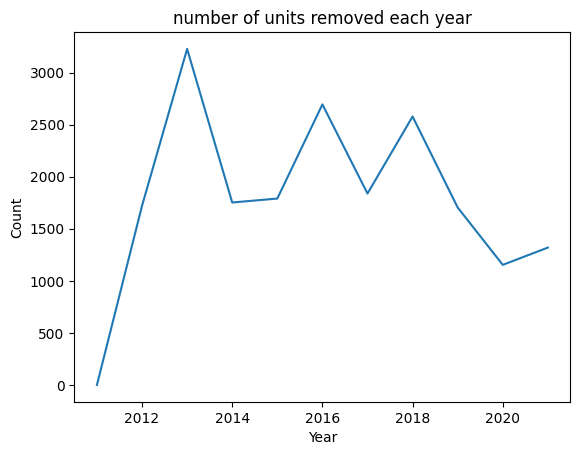

In [148]:
plt.plot(list(map(int, units_stats["Year"].to_list()[:-1])), units_stats["Removed IDs"][:-1])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("number of units removed each year")
plt.show()

### number of units added each year

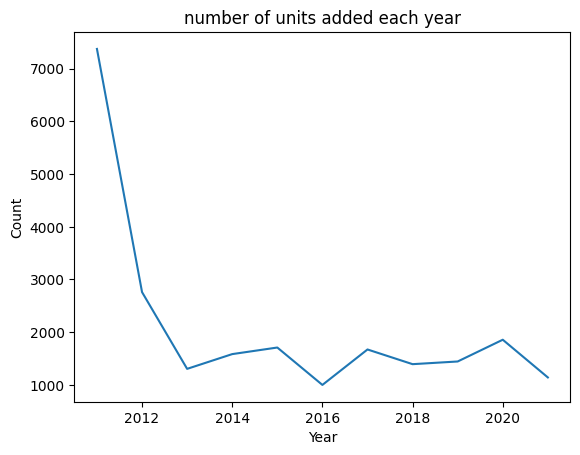

In [149]:
plt.plot(list(map(int, units_stats["Year"].to_list()[:-1])), units_stats["New IDs"][:-1])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("number of units added each year")
plt.show()

### Cable, DSL and Fiber counts per year

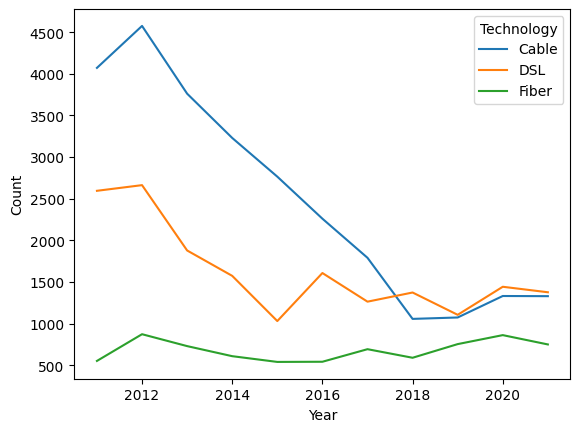

In [150]:
ax = tech_stats_df[["Cable", "DSL", "Fiber", "Year"]].plot(x="Year")
ax.set_ylabel("Count")
plt.show()

### ISP count each year

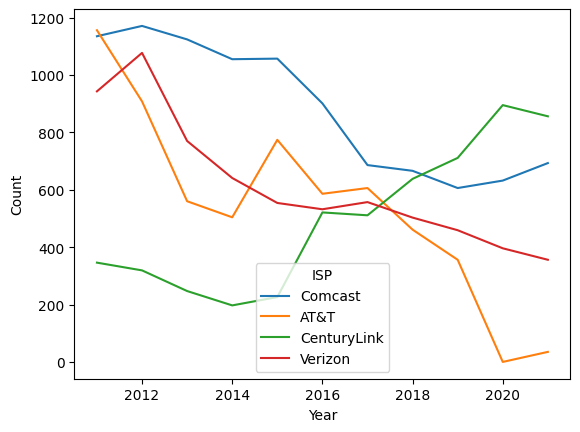

In [190]:
ax = isp_stats_df[["Comcast", "AT&T", "CenturyLink", "Verizon", "Year"]].plot(x="Year")
ax.set_ylabel("Count")
plt.show()

# Combine unit profile and excluded_unit files

In [213]:
UNIT_PROFILE_FILE = {
    "2011" : "../unit_profile_files/unit-profile-march2011.csv", # report yr'11
    "2012" : "../unit_profile_files/unit-profile-combined2012.csv", # report yr'12
    "2013" : "../unit_profile_files/unit-profile-sept2013.csv",
    "2014" : "../unit_profile_files/unit-profile-sept2014.csv",
    "2015" : "../unit_profile_files/unit-profile-sept2015.csv",
    "2016" : "../unit_profile_files/unit-profile-sept2016.csv",
    "2017" : "../unit_profile_files/unit-profile-sept2017.csv",
    "2018" : "../unit_profile_files/unit-profile-sept2018.csv",
    "2019" : "../unit_profile_files/unit-profile-sept2019.csv", 
    "2020" : "../unit_profile_files/unit-profile-sept2020.csv",
    "2021" : "../unit_profile_files/unit-profile-sept2021.csv",
}

# use a dict in the filter_data.py file
EXCLUDE_UNITS_FILE = {
    "2011": "", # report yr'11
    "2012": "../unit_profile_files/units-excluded-combined2012.xlsx", # report yr'12
    "2013": "",
    "2014" : "",
    "2015" : "../unit_profile_files/units-excluded-sept2015.xlsx",
    "2016" : "../unit_profile_files/units-excluded-sept2016.xlsx",
    "2017" : "../unit_profile_files/units-excluded-sept2017.xlsx",
    "2018" : "../unit_profile_files/units-excluded-sept2018.xlsx",
    "2019" : "../unit_profile_files/units-excluded-sept2019.xlsx", 
    "2020" : "../unit_profile_files/units-excluded-sept2020.xlsx",
    "2021" : "../unit_profile_files/units-excluded-sept2021.xlsx",  
}

unit_isp_mapping = {}
start_yr = 2011

prev_df = pd.DataFrame([], columns=["Unit ID", "ISP", "Technology"])
tech_stats_df = pd.DataFrame()
isp_stats_df = pd.DataFrame()
units_stats = []

# for id, unit_file in enumerate(unit_files):
for year, unit_file in UNIT_PROFILE_FILE.items():
    profile = pd.read_csv(unit_file)

    # year = start_yr + id
    if EXCLUDE_UNITS_FILE.get(year, False):
        excluded_df = pd.read_excel(EXCLUDE_UNITS_FILE.get(year), sheet_name=0)
        excluded_df.rename(columns={excluded_df.columns[1]: "ISP", excluded_df.columns[0]: "Unit ID"}, inplace=True)
        profile = pd.concat([profile, excluded_df]).drop_duplicates(subset=["Unit ID"]).reset_index(drop=True)

    # for 2020 and 2018
    profile["ISP"] = profile["ISP"].str.strip()
    profile["ISP"] = profile["ISP"].replace("Verizon DSL", "Verizon")
    profile["ISP"] = profile["ISP"].replace("Verizon Fiber", "Verizon")
    profile["ISP"] = profile["ISP"].replace("Verizon Wireless", "Verizon")
    profile["ISP"] = profile["ISP"].replace("Hawaiian Telcom", "Hawaiian Telecom")
    # for 2016
    profile["ISP"] = profile["ISP"].replace("AT&T DSL", "AT&T")
    profile["ISP"] = profile["ISP"].replace("AT&T IPBB", "AT&T")
    profile["ISP"] = profile["ISP"].replace("Cincinnati Bell DSL", "Cincinnati Bell")
    profile["ISP"] = profile["ISP"].replace("Cincinnati Bell Fiber", "Cincinnati Bell")
    profile["ISP"] = profile["ISP"].replace("Frontier DSL", "Frontier")
    profile["ISP"] = profile["ISP"].replace("Frontier Fiber", "Frontier")
    profile["ISP"] = profile["ISP"].replace("Time Warner Cable", "TimeWarner")

    profile["Technology"] = profile["Technology"].str.strip()
    profile["Technology"] = profile["Technology"].replace("CABLE", "Cable")
    profile["Technology"] = profile["Technology"].replace("CABLE - BUSINESS", "Cable")
    profile["Technology"] = profile["Technology"].replace("FIBER", "Fiber")
    profile["Technology"] = profile["Technology"].replace("SATELLITE", "Satellite")
    profile["Technology"] = profile["Technology"].replace("SAT", "Satellite")

    stats_isp = profile.groupby(['ISP']).agg({'Unit ID': 'count'})
    stats_tech = profile.groupby(['Technology']).agg({'Unit ID': 'count'})
    stats_isp = stats_isp.T
    stats_tech = stats_tech.T
    stats_isp.insert(loc=0, column="Year", value=int(year))
    stats_tech.insert(loc=0, column="Year", value=int(year))
    tech_stats_df = pd.concat([tech_stats_df, stats_tech]).reset_index(drop=True)
    isp_stats_df = pd.concat([isp_stats_df, stats_isp]).reset_index(drop=True)
    # print(stats_isp.to_markdown(tablefmt="grid"))
    # print(stats_tech.to_markdown(tablefmt="grid"))


    prev_ids = set(prev_df["Unit ID"].unique().tolist())
    new_ids = set(profile["Unit ID"].unique().tolist())
    units_stats.append([
        f"{int(year)}", # year
        len(new_ids), # count of ids"
        len(prev_ids - new_ids), # removed IDs
        len(new_ids - prev_ids), # new IDS
    ])

    
    profile["combined"] = profile[["ISP", "Technology"]].values.tolist()
    temp_dict = dict(zip(profile["Unit ID"], profile["combined"]))
    unit_isp_mapping.update(temp_dict)
    prev_df = profile.copy()

combined_unit_profile = pd.DataFrame([[unit_id, str(operator_name).strip(), str(operator_technology).strip()] for unit_id, (operator_name, operator_technology) in unit_isp_mapping.items()],
                       columns=["Unit ID", "ISP", "Technology"])
units_stats = pd.DataFrame(units_stats, columns=["Year", "Count", "Removed IDs", "New IDs"])
# units_stats["Percentage"] = round((units_stats["Count"]/units_stats["New IDs"].sum())*100, 1)

# fill nan with 0
tech_stats_df = tech_stats_df.fillna(0)
isp_stats_df = isp_stats_df.fillna(0)

# drop first column containing on value Unit ID after performing group by agg
# tech_stats_df.drop(columns=tech_stats_df.columns[0], axis=1, inplace=True)
# isp_stats_df.drop(columns=isp_stats_df.columns[0], axis=1, inplace=True)

## Overall summary 

### count trend over the years

In [214]:
units_stats.loc['Total'] = units_stats[['New IDs']].sum()
units_stats = units_stats.fillna('')
print(units_stats.to_markdown(tablefmt="grid"))

+-------+--------+---------+---------------+-----------+
|       | Year   | Count   | Removed IDs   |   New IDs |
+=======+========+=========+===============+===========+
| 0     | 2011   | 7377.0  | 0.0           |      7377 |
+-------+--------+---------+---------------+-----------+
| 1     | 2012   | 8416.0  | 1721.0        |      2760 |
+-------+--------+---------+---------------+-----------+
| 2     | 2013   | 6492.0  | 3227.0        |      1303 |
+-------+--------+---------+---------------+-----------+
| 3     | 2014   | 6323.0  | 1752.0        |      1583 |
+-------+--------+---------+---------------+-----------+
| 4     | 2015   | 6241.0  | 1790.0        |      1708 |
+-------+--------+---------+---------------+-----------+
| 5     | 2016   | 6039.0  | 1659.0        |      1457 |
+-------+--------+---------+---------------+-----------+
| 6     | 2017   | 6034.0  | 1725.0        |      1720 |
+-------+--------+---------+---------------+-----------+
| 7     | 2018   | 5855.0  | 18

### ISP count over the years

In [216]:
print(isp_stats_df.to_markdown(tablefmt="grid"))

+----+--------+--------+---------------+---------------+---------------+-----------+-------------+-----------+-------+------------+----------+-----------+------------+---------+--------------+-----------+-------------------+--------------+-----------------+-------+------------+-------------------+-------------+-----------+------------+--------------------+---------------+-------+---------------+-----------+----------+-------+--------------------------+---------------+----------------+--------------------+----------------------+
|    |   Year |   AT&T |   Brighthouse |   Cablevision |   CenturyLink |   Charter |   Clearwire |   Comcast |   Cox |   Frontier |   Hughes |   Insight |   Mediacom |   Qwest |   TimeWarner |   Verizon |   Wildblue/ViaSat |   Windstream |   Miscellaneous |   RCN |   CableONE |   Cincinnati Bell |   EarthLink |   EnTouch |   Fluidata |   Hawaiian Telecom |   Oceanic TWC |   Sky |   CABLEVISION |   Optimum |   Rogers |   TWC |   Hargray Communications |   PenTele

## Technology count over the years

In [185]:
print(tech_stats_df.to_markdown(tablefmt="grid"))

+----+--------+---------+-------+---------+-------------+------------+----------+--------+----------+--------+-----------+------------------+
|    |   Year |   Cable |   DSL |   Fiber |   Satellite |   WIRELESS |   REMOVE |   MISC |   UVERSE |   IPBB |   Unknown |   Fixed Wireless |
+====+========+=========+=======+=========+=============+============+==========+========+==========+========+===========+==================+
|  0 |   2011 |    4072 |  2595 |     551 |          67 |         83 |        0 |      0 |        0 |      0 |         0 |                0 |
+----+--------+---------+-------+---------+-------------+------------+----------+--------+----------+--------+-----------+------------------+
|  1 |   2012 |    4576 |  2663 |     872 |         116 |         53 |        0 |      0 |        0 |      0 |         0 |                0 |
+----+--------+---------+-------+---------+-------------+------------+----------+--------+----------+--------+-----------+------------------+
|  2 |

## Visualizations of trend per year

### count per year

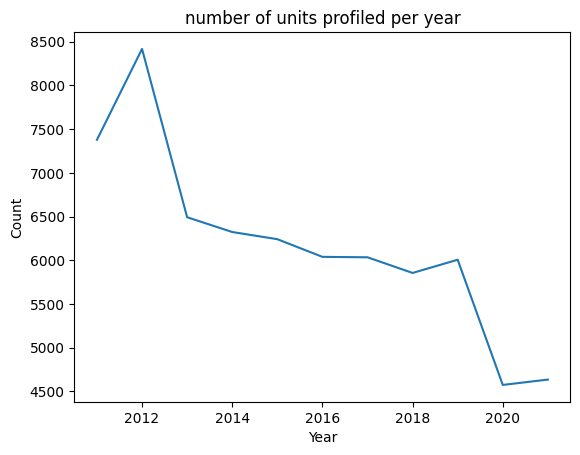

In [186]:
plt.plot(list(map(int, units_stats["Year"].to_list()[:-1])), units_stats["Count"][:-1])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("number of units profiled per year")
plt.show()

### number of units removed each year

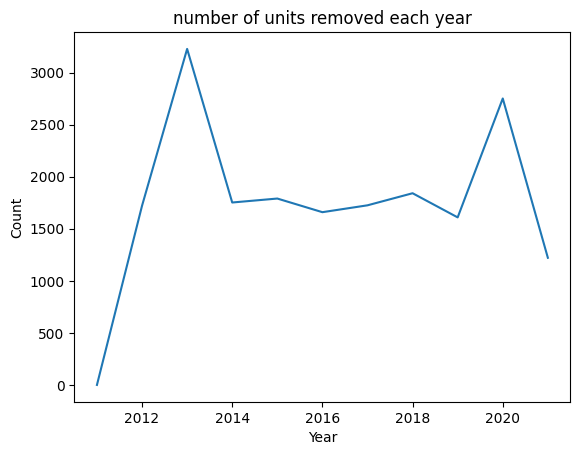

In [187]:
plt.plot(list(map(int, units_stats["Year"].to_list()[:-1])), units_stats["Removed IDs"][:-1])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("number of units removed each year")
plt.show()

### number of units added each year

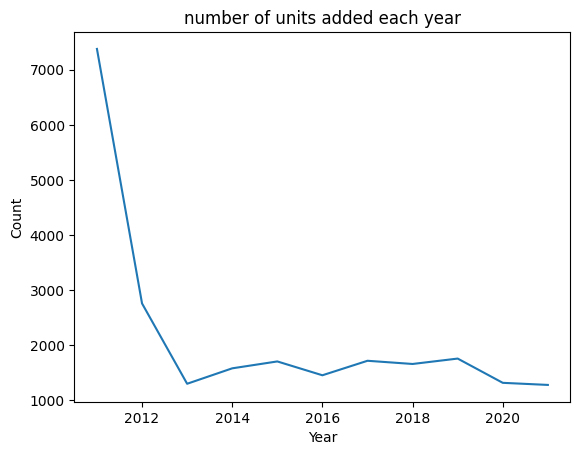

In [188]:
plt.plot(list(map(int, units_stats["Year"].to_list()[:-1])), units_stats["New IDs"][:-1])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("number of units added each year")
plt.show()

### Cable, DSL and Fiber counts per year

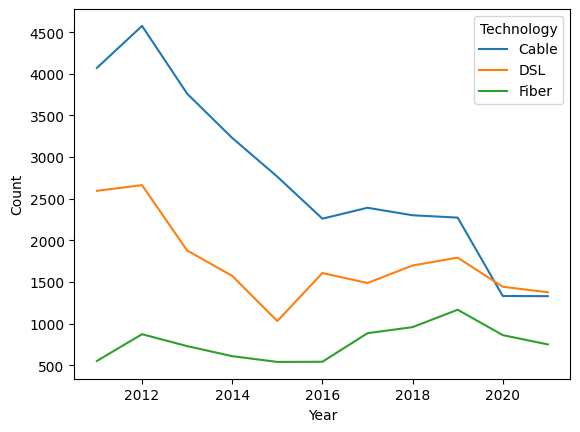

In [189]:
ax = tech_stats_df[["Cable", "DSL", "Fiber", "Year"]].plot(x="Year")
ax.set_ylabel("Count")
plt.show()

### ISP count each year

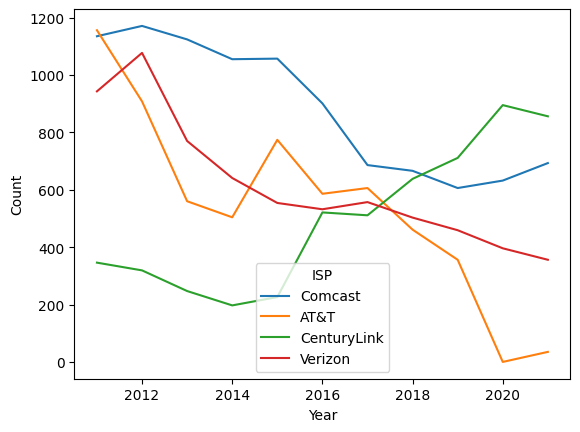

In [191]:
ax = isp_stats_df[["Comcast", "AT&T", "CenturyLink", "Verizon", "Year"]].plot(x="Year")
ax.set_ylabel("Count")
plt.show()

# Random experimentation

In [192]:
excluded_df = pd.read_excel('../unit_profile_files/units-excluded-sept2015.xlsx', sheet_name=0)

In [193]:
excluded_df.rename(columns={excluded_df.columns[1]: "ISP",excluded_df.columns[0]: "Unit ID"}, inplace=True)

In [194]:
excluded_df.head()

,Unit ID,ISP,Reason,Download Tier,Upload Tier
0,431,Verizon,Insufficient N for ISP and download/upload,15,5
1,439,Cox,Insufficient N for ISP and download/upload,5,1
2,447,Verizon,Insufficient N for ISP and download/upload,35,35
3,476,CenturyLink,Insufficient N for ISP and download/upload,0.512,0.256
4,477,Verizon,Insufficient N for ISP and download/upload,35,35


In [195]:
unit_profile = pd.read_csv('../unit_profile_files/unit-profile-sept2015.csv')

In [196]:
unit_profile.head()

,Unit ID,ISP,Technology,STATE,CENSUS,timezone_offset,timezone_offset_dst,Download,Upload
0,382,AT&T,UVERSE,SC,SOUTH,-5,-4,12,1
1,405,AT&T,UVERSE,IL,MIDWEST,-6,-5,6,1
2,450,AT&T,UVERSE,OH,MIDWEST,-5,-4,6,1
3,463,AT&T,UVERSE,IL,MIDWEST,-6,-5,18,1.5
4,464,AT&T,DSL,OH,MIDWEST,-5,-4,3,0.384


In [197]:
new_df = pd.concat([unit_profile, excluded_df]).drop_duplicates(subset=["Unit ID"]).reset_index(drop=True)

In [198]:
unit_profile.shape

(6241, 9)

In [199]:
excluded_df.shape

(667, 5)

In [200]:
unitsA = set(unit_profile["Unit ID"].unique().tolist())
unitsB = set(excluded_df["Unit ID"].unique().tolist())

In [201]:
len(unitsA.intersection(unitsB))

667

In [202]:
new_df.shape

(6241, 12)

In [203]:
new_df.tail()

,Unit ID,ISP,Technology,STATE,CENSUS,timezone_offset,timezone_offset_dst,Download,Upload,Reason,Download Tier,Upload Tier
6236,797794,Windstream,DSL,NE,MIDWEST,-6.0,-5.0,3,0.768,NaN,NaN,NaN
6237,799318,Windstream,DSL,KY,SOUTH,-5.0,-4.0,6,0.768,NaN,NaN,NaN
6238,799518,Windstream,DSL,KY,SOUTH,-5.0,-4.0,12,1,NaN,NaN,NaN
6239,801272,Windstream,DSL,KY,SOUTH,-5.0,-4.0,12,0.768,NaN,NaN,NaN
6240,805724,Windstream,DSL,FL,SOUTH,-5.0,-4.0,12,0.768,NaN,NaN,NaN


In [204]:
new_df.shape

(6241, 12)

In [205]:
new_df['Technology'] = new_df['Technology'].fillna('')

In [206]:
new_df[3390:3400]

,Unit ID,ISP,Technology,STATE,CENSUS,timezone_offset,timezone_offset_dst,Download,Upload,Reason,Download Tier,Upload Tier
3390,9575,Frontier,REMOVE,DC,SOUTH,-6.0,-5.0,REMOVE,REMOVE,NaN,NaN,NaN
3391,9707,Frontier,DSL,WA,WEST,-6.0,-5.0,5,0.768,NaN,NaN,NaN
3392,9723,Frontier,DSL,MN,MIDWEST,-6.0,-5.0,6,0.384,NaN,NaN,NaN
3393,9852,Frontier,FIBER,IN,MIDWEST,-5.0,-4.0,30,30,NaN,NaN,NaN
3394,9897,Frontier,DSL,IL,MIDWEST,-6.0,-5.0,3,0.768,NaN,NaN,NaN
3395,9985,Frontier,DSL,MN,MIDWEST,-6.0,-5.0,6,0.384,NaN,NaN,NaN
3396,10075,Frontier,FIBER,OR,WEST,-8.0,-7.0,35,15,NaN,NaN,NaN
3397,11097,Frontier,DSL,OH,MIDWEST,-5.0,-4.0,0.768,0.128,NaN,NaN,NaN
3398,11522,Frontier,DSL,PA,NORTHEAST,-5.0,-4.0,3,0.384,NaN,NaN,NaN
3399,11895,Frontier,DSL,PA,NORTHEAST,-5.0,-4.0,3,0.384,NaN,NaN,NaN


In [207]:
new_df[new_df["Unit ID"] == 24559649]

,Unit ID,ISP,Technology,STATE,CENSUS,timezone_offset,timezone_offset_dst,Download,Upload,Reason,Download Tier,Upload Tier
